<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/U2_S3_D3_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [2]:
!pip install -U matplotlib  
!pip install seaborn==0.9.0 -q


Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.2)


In [0]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

In [0]:
df.describe()

In [0]:
df['pm2.5'].plot.hist();

In [0]:
np.log(df['pm2.5'].dropna()).plot.hist();


In [4]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Pretend R code

```
ols1 <- lm(y ~ x1 + x2 + (x1 * x1))
summary(ols1)
```

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')
df.head()

In [0]:
df.shape

(3395, 20)

In [0]:
df.isna().sum()

In [0]:
df = df.replace('?', np.nan)
df.isna().sum()

In [0]:
df.dtypes

In [0]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df['APM']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.9727919594327304

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

In [0]:
df.LeagueIndex.value_counts()

In [0]:
# Let's say we want to answer "What are the fastest 10% of SC players like?"
# That means quantile regression with q=0.9

# First we need a formula, with our friend twiddle
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary()

In [0]:
quant_reg.predict(X)[:10]

In [0]:
linear_reg.predict(X)[:10]

In [0]:
df.TotalHours.value_counts()

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [0]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy import stats

In [10]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [0]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [0]:
# TODO - your work here! Also, add text cells for written questions.
d = bwt_df.copy()

In [0]:
d.info()

In [15]:
# # How does linear regression handle it? Courtesy of Daniel
X = d.drop('bwt', axis='columns')
y = d['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2579534937842991

Pretty poor linear regression model fit to the data, let's chec the coefficients

In [16]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.4439783392634531
parity -3.327199613351645
age -0.008950305361154154
height 1.1540203642500357
weight 0.05016502707680326
smoke -8.40073348432133


In [17]:
d.bwt.median()

120.0

In [34]:
q = stats.percentileofscore(d.bwt, 90)/100
q

0.05664395229982964

In [18]:
d.columns

Index(['bwt', 'gestation', 'parity', 'age', 'height', 'weight', 'smoke'], dtype='object')

In [37]:
#Quantile regression
quant_formula = 'bwt ~ ' + ' + '.join(d.drop('bwt', axis='columns').columns)


quant_mod = smf.quantreg(quant_formula, data=d)
quant_reg = quant_mod.fit(q=q)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.228
Method:                 Least Squares   Sparsity:                        132.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        22:14:28   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.271     -32.393
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1.337
age           -0.0836      0.172     -0.486      0.627      -0.421       0.254
height         1.2308      0.437      2.817      0.005       0.374       2.088
weight        -0.1191      0.058     -2.048      0.041      -0.233      -0.005
smoke         -8.7485      1.855     -4.716      0.000     -12.388      -5.109
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

from the summary above, smoking is the factor influencing the birth weight the most, the p-value=000 indicates the significance of the factor, high t indicates on influence, and coefficient shows the decrease in weight by 8.83 ounces if the mother is a smoker. Also, parity is the second factor influencing the weight.
On the other side, the gestation has a positive impact on a baby's weight, also the higher the baby's height, the bigger the weight is. 

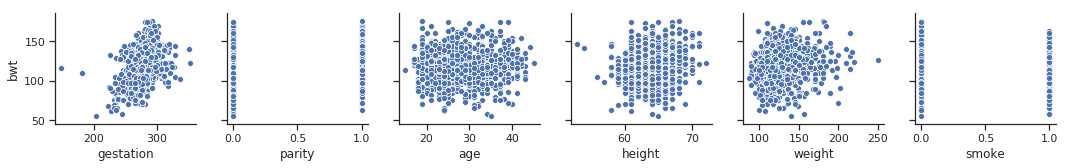

In [38]:
#Let's see if some polynomial features might help to improve the model
sns.set(style='ticks', color_codes=True)
x_columns = d.columns.drop(['bwt'])
sns.pairplot(data=d, y_vars=['bwt'], x_vars=x_columns);

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


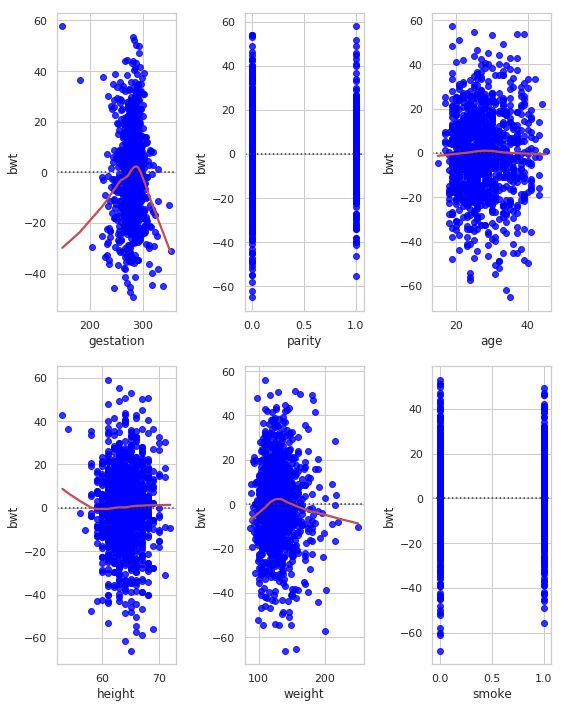

In [39]:
# Check on residual plots
X = d.drop(['bwt'], axis=1)
y = d['bwt']

sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8,10));

position_list = []
for i in range(2):
    for j in range(3):
        position_list.append((i,j))
        
for col, pos in zip(X.columns, position_list):
    sns.residplot(X[col], y, lowess=True, color="r", ax=axs[pos[0]][pos[1]],
                  scatter_kws={'color':'blue'});
plt.tight_layout();

In [0]:
d['weight_squared'] = d['weight']**2
d['gestation_squared'] = d['gestation'] **2

In [41]:
#Quantile regression
quant_formula = 'bwt ~ ' + ' + '.join(d.drop('bwt', axis='columns').columns)


quant_mod = smf.quantreg(quant_formula, data=d)
quant_reg = quant_mod.fit(q=.375)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1418
Model:                       QuantReg   Bandwidth:                       6.605
Method:                 Least Squares   Sparsity:                        38.47
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        22:14:51   Df Residuals:                     1165
                                        Df Model:                            8
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0037     58.550   -6.3e-05      1.000    -114.880     114.872
gestation            -0.0472      0.408     -0.116      0.908      -0.849       0.754
parity               -4.3598      1.332     -3.274      0.001      -6.973      -1.747
age                  -0.1040      0.102     -1.025      0.306      -0.303       0.095
height                0.9499      0.252      3.762      0.000       0.455       1.445
weight                0.0615      0.207      0.297      0.766      -0.345       0.468
smoke                -9.2198      1.120     -8.230      0.000     -11.418      -7.022
weight_squared    -6.263e-05      0.001     -0.089      0.929      -0.001       0.001
gestation_squared     0.0009      0.001      1.150      0.251      -0.001       0.002
=====================================================================================

The condition number is large, 8.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

polynomial features did not improve the model, so I'll drop them

In [0]:
d.drop(['gestation_squared', 'weight_squared'], axis=1, inplace=True)

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?

If a mother smokes, the likelihood of an at-risk baby is higher

- What can expectant mothers be told to help mitigate this risk?

Expectant mother should stop smoking, and try to take care of herself to have a full gestation period before delivery


## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model